In [ ]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing

In [ ]:
#Pima
from google.colab import files
data_to_load = files.upload()

Saving diabetes.csv to diabetes.csv


In [ ]:
X = pd.read_csv('diabetes.csv')

In [ ]:
X

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1
...,...,...,...,...,...,...,...,...,...
763,10,101,76,48,180,32.9,0.171,63,0
764,2,122,70,27,0,36.8,0.340,27,0
765,5,121,72,23,112,26.2,0.245,30,0
766,1,126,60,0,0,30.1,0.349,47,1


In [ ]:
X.isnull().values.any()

False

In [ ]:
y = X.pop('Outcome')

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, stratify=y)

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score

In [ ]:
!pip install optuna

     |████████████████████████████████| 308 kB 20.3 MB/s 
     |████████████████████████████████| 81 kB 8.7 MB/s 
     |████████████████████████████████| 210 kB 62.1 MB/s 
     |████████████████████████████████| 78 kB 6.7 MB/s 
     |████████████████████████████████| 49 kB 5.9 MB/s 
     |████████████████████████████████| 113 kB 65.9 MB/s 
     |████████████████████████████████| 146 kB 33.7 MB/s 
  Created wheel for pyperclip: filename=pyperclip-1.8.2-py3-none-any.whl size=11137 sha256=384ada686f1ab32bc176694d72ed8de14a0cee6f6d7be25ca83c03af53f0a8d6
  Stored in directory: /root/.cache/pip/wheels/9f/18/84/8f69f8b08169c7bae2dde6bd7daf0c19fca8c8e500ee620a28
Successfully built pyperclip


In [ ]:
import optuna
optuna.logging.set_verbosity(optuna.logging.ERROR)

# Grid search

In [ ]:
def objective_gs(trial):
    C_vals = trial.suggest_float("C", 1e-5, 1e5)
    gamma_vals = trial.suggest_float('gamma', 1e-5, 1e5)
    clf_obj = SVC(kernel='rbf', C=C_vals, gamma=gamma_vals)
    score = cross_val_score(clf_obj, X_train, y_train, scoring='accuracy', n_jobs=-1, cv=5)
    accuracy = score.mean()
    return accuracy

In [ ]:
%%time
search_space = {'C': np.logspace(-5, 5, 20), 'gamma': np.logspace(-5, 5 ,20)}
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.GridSampler(search_space))
study.optimize(objective_gs)

CPU times: user 12.8 s, sys: 442 ms, total: 13.3 s
Wall time: 1min 10s


In [ ]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [ ]:
print('SVC, grid search, best trial:')
print(study.best_trial.params)
print('SVC, grid search, best accuracy:')
print(study.best_value)
print('SVC, grid search, best trial number:')
print(study.best_trial.number)

SVC, grid search, best trial:
{'C': 1.8329807108324339, 'gamma': 1e-05}
SVC, grid search, best accuracy:
0.7561093804084458
SVC, grid search, best trial number:
297


In [ ]:
fig = optuna.visualization.plot_contour(study, params=["C", "gamma"])
fig.show()

In [ ]:
def evaluate_accuracy(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    accuracy = (pred == y_test).mean()
    return accuracy

In [ ]:
model = SVC(kernel='rbf', C=study.best_trial.params['C'], gamma=study.best_trial.params['gamma'])
print('SVC, grid search, accuracy on test:')
print(evaluate_accuracy(model, X_train, y_train, X_test, y_test))

SVC, grid search, accuracy on test:
0.7662337662337663


# Random search

In [ ]:
def objective(trial):
    C_vals = trial.suggest_float("C", 1e-5, 1e5, log=True)
    gamma_vals = trial.suggest_float('gamma', 1e-5, 1e5, log=True)
    clf_obj = SVC(kernel='rbf', C=C_vals, gamma=gamma_vals)
    score = cross_val_score(clf_obj, X_train, y_train, scoring='accuracy', n_jobs=-1, cv=5)
    accuracy = score.mean()
    return accuracy

In [ ]:
%%time
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.RandomSampler())
study.optimize(objective, n_trials=400)

CPU times: user 9.96 s, sys: 342 ms, total: 10.3 s
Wall time: 50.9 s


In [ ]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [ ]:
print('SVC, random search, best trial:')
print(study.best_trial.params)
print('SVC, random_search, best accuracy:')
print(study.best_value)
print('SVC, random search, best trial number')
print(study.best_trial.number)

SVC, random search, best trial:
{'C': 1.4451795431697043, 'gamma': 3.3622408642463554e-05}
SVC, random_search, best accuracy:
0.7486673589477327
SVC, random search, best trial number
266


In [ ]:
fig = optuna.visualization.plot_contour(study, params=["C", "gamma"])
fig.show()

In [ ]:
model = SVC(kernel='rbf', C=study.best_trial.params['C'], gamma=study.best_trial.params['gamma'])
print('SVC, random search, accuracy on test:')
print(evaluate_accuracy(model, X_train, y_train, X_test, y_test))

SVC, random search, accuracy on test:
0.7835497835497836


# TPE

In [ ]:
%%time
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=400)

CPU times: user 12.1 s, sys: 333 ms, total: 12.4 s
Wall time: 55.6 s


In [ ]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [ ]:
print('SVC, TPE, best trial:')
print(study.best_trial.params)
print('SVC, TPE, best accuracy:')
print(study.best_value)
print('SVC, TPE, best trial number:')
print(study.best_trial.number)

SVC, TPE, best trial:
{'C': 2.3289753044422734, 'gamma': 1.5626670893008698e-05}
SVC, TPE, best accuracy:
0.7561093804084458
SVC, TPE, best trial number:
211


In [ ]:
fig = optuna.visualization.plot_contour(study, params=["C", "gamma"])
fig.show()

In [ ]:
model = SVC(kernel='rbf', C=study.best_trial.params['C'], gamma=study.best_trial.params['gamma'])
print('SVC, TPE, accuracy on test:')
print(evaluate_accuracy(model, X_train, y_train, X_test, y_test))

SVC, TPE, accuracy on test:
0.7835497835497836


# CMA-ES

In [ ]:
%%time
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.CmaEsSampler())
study.optimize(objective, n_trials=400)

CPU times: user 10.5 s, sys: 345 ms, total: 10.8 s
Wall time: 39.2 s


In [ ]:
fig = optuna.visualization.plot_optimization_history(study)
fig.show()

In [ ]:
print('SVC, CMA-ES, best trial:')
print(study.best_trial.params)
print('SVC, CMA-ES, best accuracy:')
print(study.best_value)
print('SVC, CMA-ES, best trial number:')
print(study.best_trial.number)

SVC, CMA-ES, best trial:
{'C': 4.845446538295537, 'gamma': 1.135007674937172e-05}
SVC, CMA-ES, best accuracy:
0.7579266182069919
SVC, CMA-ES, best trial number:
193


In [ ]:
fig = optuna.visualization.plot_contour(study, params=["C", "gamma"])
fig.show()

In [ ]:
model = SVC(kernel='rbf', C=study.best_trial.params['C'], gamma=study.best_trial.params['gamma'])
print('SVC, CMA-ES, accuracy on test:')
print(evaluate_accuracy(model, X_train, y_train, X_test, y_test))

SVC, CMA-ES, accuracy on test:
0.7878787878787878


# Bayesian optimization

In [ ]:
! pip install scikit-optimize

     |████████████████████████████████| 100 kB 6.6 MB/s 


In [ ]:
from skopt import BayesSearchCV

In [ ]:
%%time 
opt = BayesSearchCV(
    SVC(kernel='rbf'), 
    {
        'C': (1e-5, 1e5, 'log-uniform'),
        'gamma': (1e-5, 1e5, 'log-uniform')
    },
    n_iter=400,
    cv=5,
    scoring='accuracy'
)
opt.fit(X_train, y_train)

CPU times: user 2h 3min 19s, sys: 38min 17s, total: 2h 41min 36s
Wall time: 2h 2min 40s


In [ ]:
print('SVC, BO, best trial:')
print(opt.best_params_)
print('SVC, BO, best accuracy:')
print(opt.best_score_)
print('SVC, BO, best trial number:')
print(opt.best_index_)

SVC, BO, best trial:
OrderedDict([('C', 1.9621035437168033), ('gamma', 1e-05)])
SVC, BO, best accuracy:
0.7579612322602978
SVC, BO, best trial number:
66


In [ ]:
from skopt.plots import plot_objective, plot_convergence, plot_gaussian_process, plot_evaluations

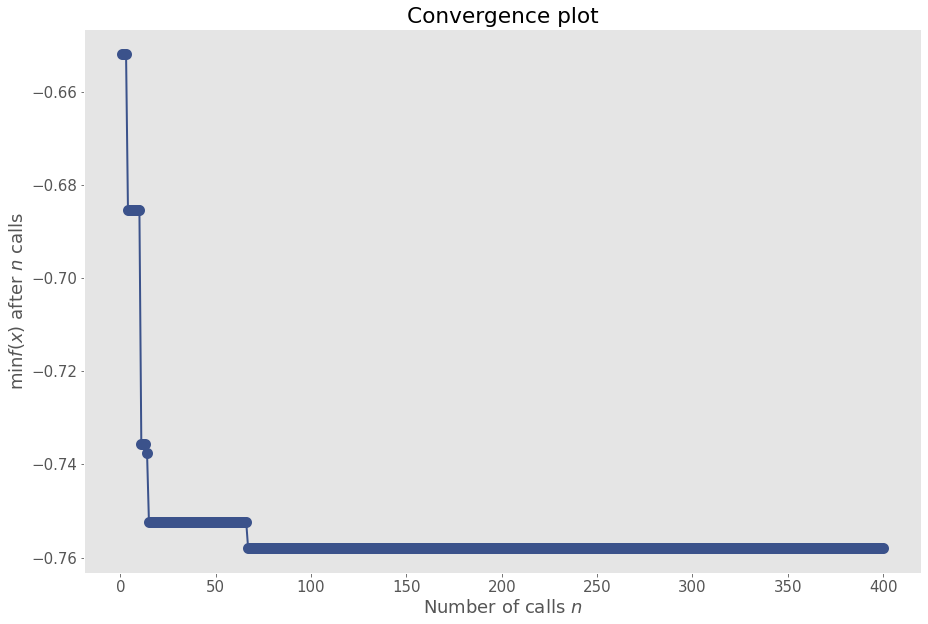

In [ ]:
plt.figure(figsize=(15, 10))
vis = plot_convergence(*opt.optimizer_results_)

<Figure size 1440x1080 with 0 Axes>

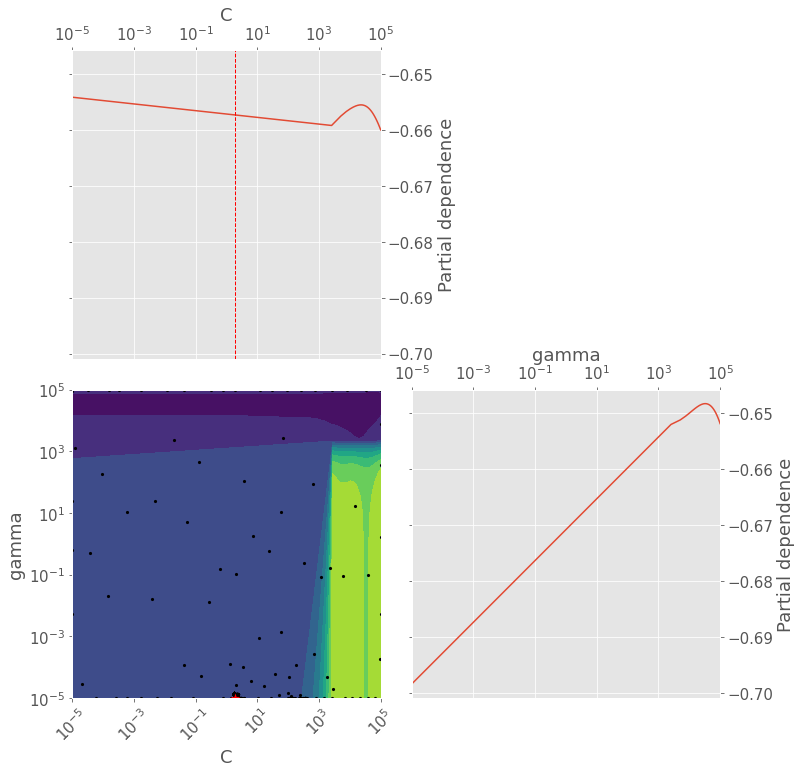

In [ ]:
plt.rc('font', size=15)
plt.rc('lines', mew=5)
plt.figure(figsize=(20, 15))
plot_objective(*opt.optimizer_results_, size=5)
plt.savefig(fname='SVC_BCW_BO.pdf')

In [ ]:
model = SVC(kernel='rbf', C=opt.best_params_['C'], gamma=opt.best_params_['gamma'])
print('SVC, BO, accuracy on test:')
print(evaluate_accuracy(model, X_train, y_train, X_test, y_test))

SVC, BO, accuracy on test:
0.7662337662337663
